In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE, f_classif
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Load the dataset
data = pd.read_csv('wdbc.csv')

# Check and print the column names
print("Columns in the dataset:")
for column in data.columns:
    print(column)


# Drop the ID column if it exists
if 'ID' in data.columns:
    data = data.drop(columns=['ID'])
    print("'ID' column dropped.")
else:
    print("'ID' column not found in the dataset.")

# Encode the target variable ('Diagnosis')
label_encoder = LabelEncoder()
data['diagnosis'] = label_encoder.fit_transform(data['diagnosis'])  # M -> 1, B -> 0

# Separate features and target
feature_names = data.drop(columns=['diagnosis']).columns.tolist()  # Save feature names
X = data.drop(columns=['diagnosis']).values
y = data['diagnosis'].values

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)


Columns in the dataset:
ID
diagnosis
Radius_mean
Texture_mean
Perimeter_mean
Area_mean
Smoothness_mean
Compactness_mean
Concavity_mean
Concave_points_mean
Symmetry_mean
Fractal_dimension_mean
Radius_se
Texture_se
Perimeter_se
Area_se
Smoothness_se
Compactness_se
Concavity_se
Concave_points_se
Symmetry_se
Fractal_dimension_se
Radius_worst
Texture_worst
Perimeter_worst
Area_worst
Smoothness_worst
Compactness_worst
Concavity_worst
Concave_points_worst
Symmetry_worst
Fractal_dimension_worst
'ID' column dropped.


feature selection

RFE

In [2]:

# Function to perform Recursive Feature Elimination (RFE)
def select_features_rfe(X, y, feature_names, n_features=20):
    print("\n=== Recursive Feature Elimination (RFE) ===")
    rfe_estimator = RandomForestClassifier(random_state=42)
    rfe_selector = RFE(estimator=rfe_estimator, n_features_to_select=n_features, step=1)
    rfe_selector = rfe_selector.fit(X, y)
    
    # Get ranking for all features
    rfe_ranking = rfe_selector.ranking_
    feature_scores = list(zip(feature_names, rfe_ranking))
    
    # Print all features with their RFE rankings
    print("\nRFE ranks for all features:")
    for feature, score in feature_scores:
        print(f"{feature}: Rank {score}")
    
    # Select top features (rank 1)
    rfe_features = [feature for feature, rank in feature_scores if rank == 1]
    print("\nTop 20 features using RFE:", rfe_features)
    
    return rfe_features


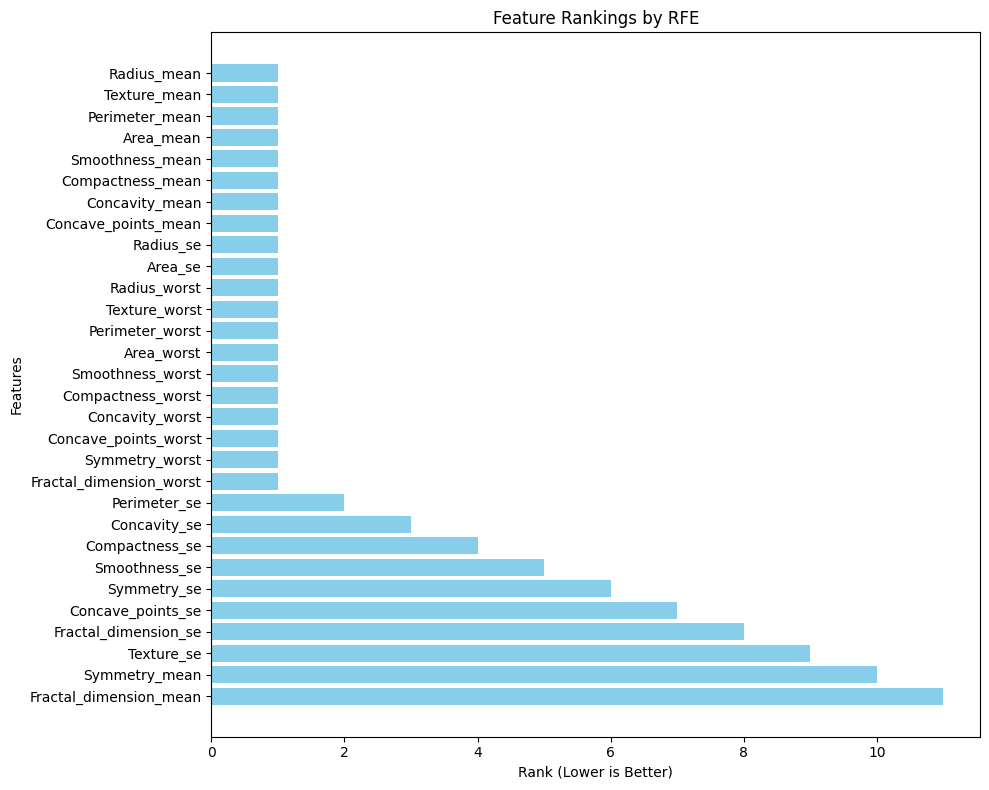

In [3]:
# Extract all feature rankings from the RFE function
rfe_estimator = RandomForestClassifier(random_state=42)
rfe_selector = RFE(estimator=rfe_estimator, n_features_to_select=20, step=1)
rfe_selector = rfe_selector.fit(X, y)

# Get feature rankings and organize them
rfe_ranking = rfe_selector.ranking_
rfe_features_with_ranks = list(zip(feature_names, rfe_ranking))

# Sort features by their rank for better visualization
sorted_rfe_features = sorted(rfe_features_with_ranks, key=lambda x: x[1])

# Separate feature names and rankings for plotting
sorted_feature_names = [name for name, rank in sorted_rfe_features]
sorted_ranks = [rank for name, rank in sorted_rfe_features]

# Plot the RFE rankings
plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_names, sorted_ranks, color='skyblue')
plt.xlabel('Rank (Lower is Better)')
plt.ylabel('Features')
plt.title('Feature Rankings by RFE')
plt.gca().invert_yaxis()  # Invert y-axis so the most important features are at the top
plt.tight_layout()
plt.show()


SRN

In [4]:
# Function to perform Signal-to-Noise Ratio (SNR) selection
def select_features_snr(X, y, feature_names, n_features=20):
    print("\n=== Signal-to-Noise Ratio (SNR) ===")
    snr_scores = []
    
    for i in range(X.shape[1]):
        mean_signal = np.mean(X[y == 1, i])  # Mean for 'M'
        mean_noise = np.mean(X[y == 0, i])   # Mean for 'B'
        std_signal = np.std(X[y == 1, i])
        std_noise = np.std(X[y == 0, i])
        
        # Avoid division by zero
        if (std_signal + std_noise) == 0:
            snr = 0
        else:
            snr = abs(mean_signal - mean_noise) / (std_signal + std_noise)
        snr_scores.append((feature_names[i], snr))
    
    # Print SNR scores for all features
    print("\nSNR scores for all features:")
    for feature, score in snr_scores:
        print(f"{feature}: {score:.4f}")
    
    # Sort features by SNR score in descending order
    snr_scores_sorted = sorted(snr_scores, key=lambda x: x[1], reverse=True)
    top_snr_features = [x[0] for x in snr_scores_sorted[:n_features]]
    print(f"\nTop {n_features} features based on SNR:", top_snr_features)
    
    return top_snr_features


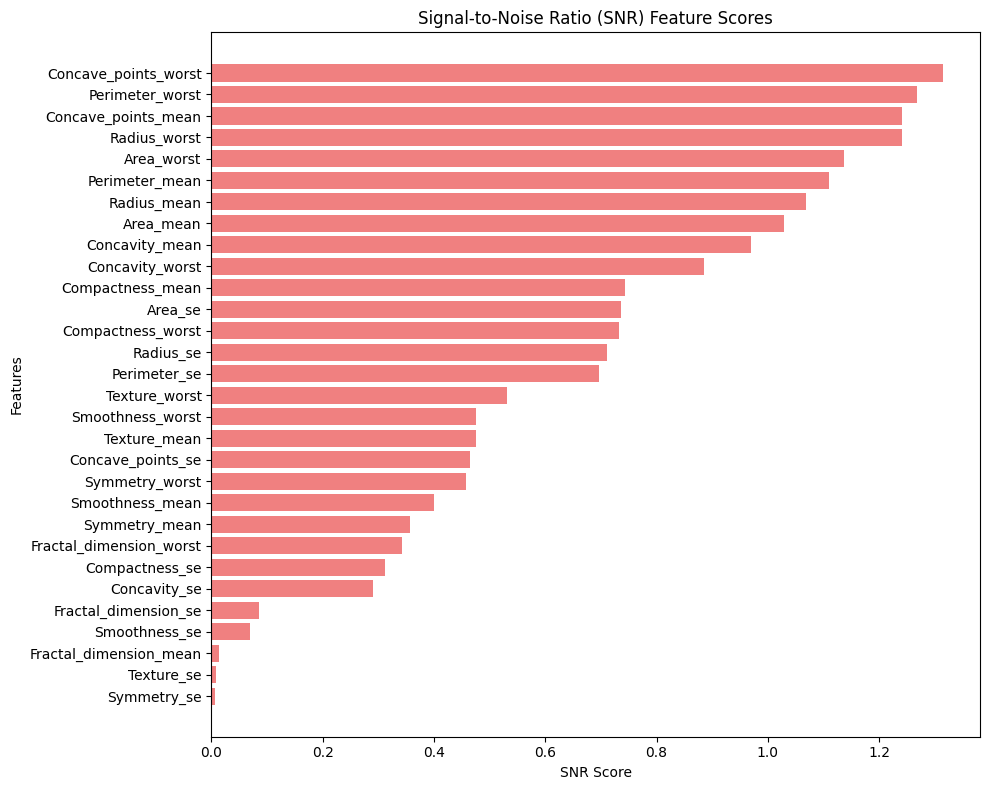


Top 20 features based on SNR: ['Concave_points_worst', 'Perimeter_worst', 'Concave_points_mean', 'Radius_worst', 'Area_worst', 'Perimeter_mean', 'Radius_mean', 'Area_mean', 'Concavity_mean', 'Concavity_worst', 'Compactness_mean', 'Area_se', 'Compactness_worst', 'Radius_se', 'Perimeter_se', 'Texture_worst', 'Smoothness_worst', 'Texture_mean', 'Concave_points_se', 'Symmetry_worst']


In [5]:
# Define the number of top features to select
n_features = 20  # Adjust this value based on your requirements

# Calculate Signal-to-Noise Ratio (SNR) for all features
snr_scores = []
for i in range(X.shape[1]):
    mean_signal = np.mean(X[y == 1, i])  # Mean for 'M'
    mean_noise = np.mean(X[y == 0, i])   # Mean for 'B'
    std_signal = np.std(X[y == 1, i])
    std_noise = np.std(X[y == 0, i])
    
    # Avoid division by zero
    if (std_signal + std_noise) == 0:
        snr = 0
    else:
        snr = abs(mean_signal - mean_noise) / (std_signal + std_noise)
    snr_scores.append((feature_names[i], snr))

# Sort features by SNR score in descending order
snr_scores_sorted = sorted(snr_scores, key=lambda x: x[1], reverse=True)
top_snr_features = [x[0] for x in snr_scores_sorted[:n_features]]

# Separate feature names and SNR scores for plotting
sorted_snr_features = [x[0] for x in snr_scores_sorted]
sorted_snr_scores = [x[1] for x in snr_scores_sorted]

# Plot the SNR scores
plt.figure(figsize=(10, 8))
plt.barh(sorted_snr_features, sorted_snr_scores, color='lightcoral')
plt.xlabel('SNR Score')
plt.ylabel('Features')
plt.title('Signal-to-Noise Ratio (SNR) Feature Scores')
plt.gca().invert_yaxis()  # Invert y-axis so that the highest scores are at the top
plt.tight_layout()
plt.show()

# Print top SNR features
print(f"\nTop {n_features} features based on SNR:", top_snr_features)


F SCORE

In [6]:
# Function to perform F-Score selection
def select_features_fscore(X, y, feature_names, n_features=20):
    print("\n=== F-Score (ANOVA) ===")
    f_values, p_values = f_classif(X, y)
    f_scores = [(feature_names[i], f_values[i]) for i in range(len(feature_names))]
    
    # Print F-Scores for all features
    print("\nF-Scores for all features:")
    for feature, score in f_scores:
        print(f"{feature}: {score:.4f}")
    
    # Sort features by F-Score in descending order
    f_scores_sorted = sorted(f_scores, key=lambda x: x[1], reverse=True)
    top_fscore_features = [x[0] for x in f_scores_sorted[:n_features]]
    print(f"\nTop {n_features} features based on F-Score:", top_fscore_features)
    
    return top_fscore_features


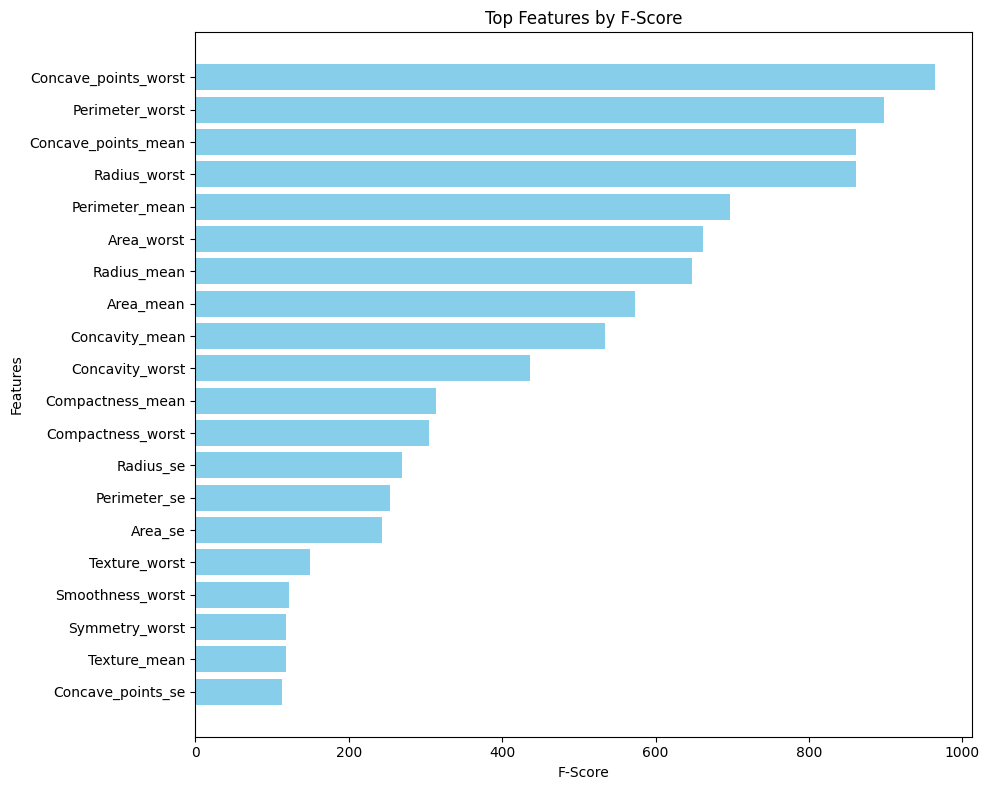


Top 20 features based on F-Score: ['Concave_points_worst', 'Perimeter_worst', 'Concave_points_mean', 'Radius_worst', 'Perimeter_mean', 'Area_worst', 'Radius_mean', 'Area_mean', 'Concavity_mean', 'Concavity_worst', 'Compactness_mean', 'Compactness_worst', 'Radius_se', 'Perimeter_se', 'Area_se', 'Texture_worst', 'Smoothness_worst', 'Symmetry_worst', 'Texture_mean', 'Concave_points_se']


In [7]:
# Number of top features to select
n_features = 20  # Adjustable based on your requirements

# Call the F-Score selection function
f_values, p_values = f_classif(X, y)
f_scores = [(feature_names[i], f_values[i]) for i in range(len(feature_names))]

# Sort features by F-Score in descending order
f_scores_sorted = sorted(f_scores, key=lambda x: x[1], reverse=True)
top_fscore_features = [x[0] for x in f_scores_sorted[:n_features]]

# Separate feature names and F-Scores for plotting
sorted_fscore_features = [x[0] for x in f_scores_sorted]
sorted_fscore_values = [x[1] for x in f_scores_sorted]

# Plot the F-Scores
plt.figure(figsize=(10, 8))
plt.barh(sorted_fscore_features[:n_features], sorted_fscore_values[:n_features], color='skyblue')
plt.xlabel('F-Score')
plt.ylabel('Features')
plt.title('Top Features by F-Score')
plt.gca().invert_yaxis()  # Invert y-axis so that the highest scores are at the top
plt.tight_layout()
plt.show()

# Print top F-Score features
print(f"\nTop {n_features} features based on F-Score:", top_fscore_features)


PCA

In [8]:
# Function to perform Principal Component Analysis (PCA)
def select_features_pca(X, feature_names, n_components=20):
    print("\n=== Principal Component Analysis (PCA) ===")
    pca = PCA(n_components=X.shape[1])  # Fit PCA with all components
    X_pca = pca.fit_transform(X)
    pca_explained_variance = pca.explained_variance_ratio_
    
    print("\nPCA explained variance ratios for all components:")
    for i, var in enumerate(pca_explained_variance):
        print(f"Principal Component {i + 1}: {var:.4f}")
    
    # PCA loadings (contributions of original features to each principal component)
    pca_loadings = pd.DataFrame(pca.components_, columns=feature_names, index=[f"PC{i+1}" for i in range(X.shape[1])])
    print("\nPCA Loadings (Contributions of original features to each principal component):")
    print(pca_loadings)
    
    # Select top n_components based on explained variance
    top_pca_components = [f"PC{i+1}" for i in range(n_components)]
    top_pca_variances = pca_explained_variance[:n_components]
    print(f"\nTop {n_components} principal components based on explained variance:")
    for pc, var in zip(top_pca_components, top_pca_variances):
        print(f"{pc}: {var:.4f}")
    
    # Calculate feature importance by summing the absolute loadings across all principal components
    feature_importance = np.abs(pca.components_).sum(axis=0)
    
    # Get the top 10 features with the highest summed importance
    top_feature_indices = np.argsort(feature_importance)[-20:]  # Get indices of top 10 features
    
    pca_top_features = [feature_names[i] for i in top_feature_indices]
    print(f"\nTop features contributing to PCA components: {pca_top_features}")
    
    # Reduce data to top n_components
    pca = PCA(n_components=n_components)
    X_pca_top = pca.fit_transform(X)
    
    return X_pca_top, pca, pca_top_features




=== Principal Component Analysis (PCA) ===

PCA explained variance ratios for all components:
Principal Component 1: 0.4427
Principal Component 2: 0.1897
Principal Component 3: 0.0939
Principal Component 4: 0.0660
Principal Component 5: 0.0550
Principal Component 6: 0.0402
Principal Component 7: 0.0225
Principal Component 8: 0.0159
Principal Component 9: 0.0139
Principal Component 10: 0.0117
Principal Component 11: 0.0098
Principal Component 12: 0.0087
Principal Component 13: 0.0080
Principal Component 14: 0.0052
Principal Component 15: 0.0031
Principal Component 16: 0.0027
Principal Component 17: 0.0020
Principal Component 18: 0.0018
Principal Component 19: 0.0016
Principal Component 20: 0.0010
Principal Component 21: 0.0010
Principal Component 22: 0.0009
Principal Component 23: 0.0008
Principal Component 24: 0.0006
Principal Component 25: 0.0005
Principal Component 26: 0.0003
Principal Component 27: 0.0002
Principal Component 28: 0.0001
Principal Component 29: 0.0000
Principal Compo

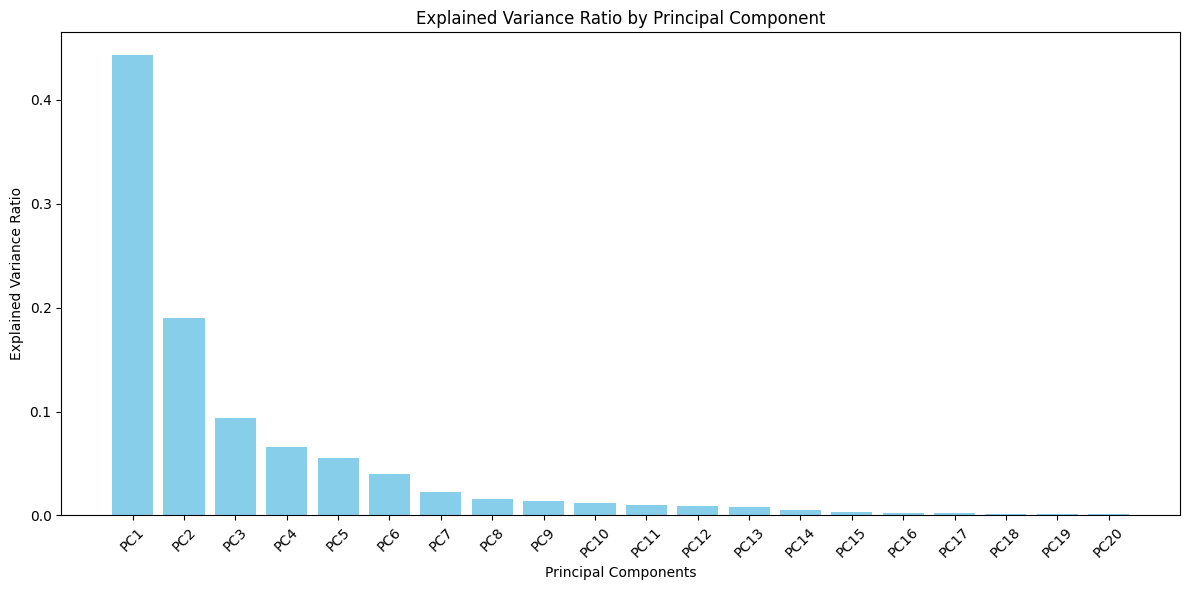

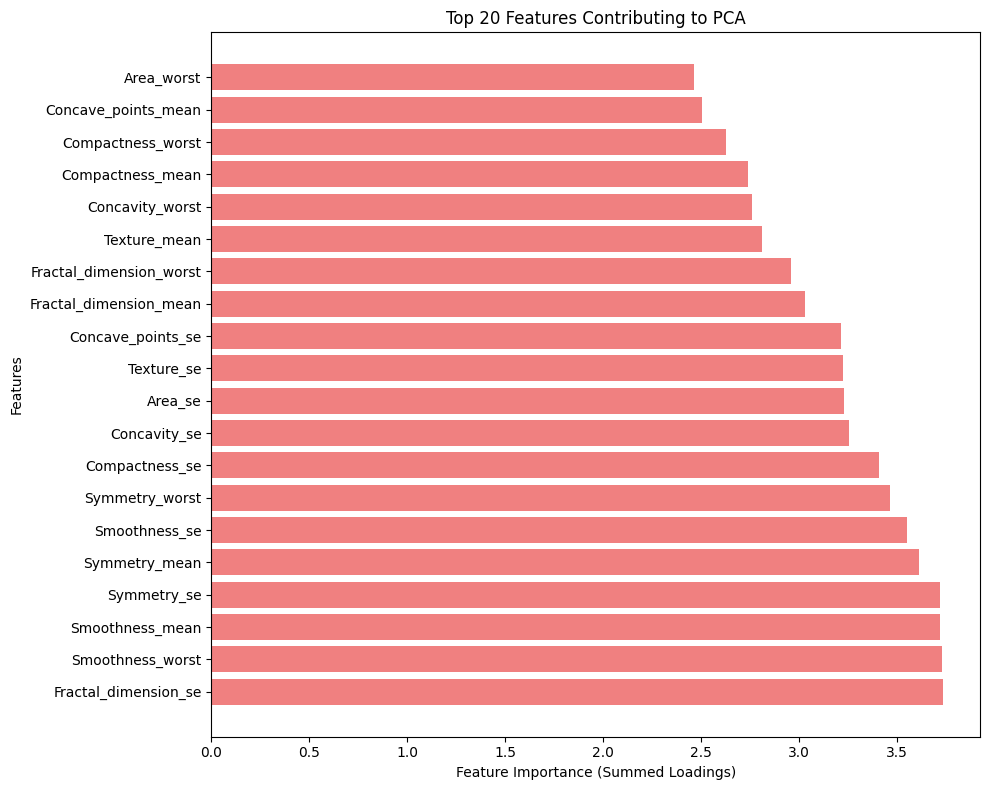

In [9]:
# Perform PCA and extract results
n_components = 20  # Specify the number of components
X_pca_top, pca_model, pca_top_features = select_features_pca(X, feature_names, n_components)

# Explained Variance Ratio Bar Chart
explained_variance = pca_model.explained_variance_ratio_
components = [f"PC{i+1}" for i in range(len(explained_variance))]

plt.figure(figsize=(12, 6))
plt.bar(components[:n_components], explained_variance[:n_components], color='skyblue')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Component')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Feature Importance Bar Chart (Top Contributing Features)
feature_importance = np.abs(pca_model.components_).sum(axis=0)
top_feature_indices = np.argsort(feature_importance)[-n_components:]  # Top n features
top_feature_names = [feature_names[i] for i in top_feature_indices]
top_feature_scores = feature_importance[top_feature_indices]

plt.figure(figsize=(10, 8))
plt.barh(top_feature_names, top_feature_scores, color='lightcoral')
plt.xlabel('Feature Importance (Summed Loadings)')
plt.ylabel('Features')
plt.title(f'Top {n_components} Features Contributing to PCA')
plt.gca().invert_yaxis()  # Invert to have highest at the top
plt.tight_layout()
plt.show()


SELECTION METHOD

In [10]:
# Apply Feature Selection Methods
rfe_selected_features = select_features_rfe(X, y, feature_names, n_features=20)
snr_selected_features = select_features_snr(X, y, feature_names, n_features=20)
fscore_selected_features = select_features_fscore(X, y, feature_names, n_features=20)
X_pca_top, pca_model, pca_top_features = select_features_pca(X, feature_names, n_components=20)



=== Recursive Feature Elimination (RFE) ===

RFE ranks for all features:
Radius_mean: Rank 1
Texture_mean: Rank 1
Perimeter_mean: Rank 1
Area_mean: Rank 1
Smoothness_mean: Rank 1
Compactness_mean: Rank 1
Concavity_mean: Rank 1
Concave_points_mean: Rank 1
Symmetry_mean: Rank 10
Fractal_dimension_mean: Rank 11
Radius_se: Rank 1
Texture_se: Rank 9
Perimeter_se: Rank 2
Area_se: Rank 1
Smoothness_se: Rank 5
Compactness_se: Rank 4
Concavity_se: Rank 3
Concave_points_se: Rank 7
Symmetry_se: Rank 6
Fractal_dimension_se: Rank 8
Radius_worst: Rank 1
Texture_worst: Rank 1
Perimeter_worst: Rank 1
Area_worst: Rank 1
Smoothness_worst: Rank 1
Compactness_worst: Rank 1
Concavity_worst: Rank 1
Concave_points_worst: Rank 1
Symmetry_worst: Rank 1
Fractal_dimension_worst: Rank 1

Top 20 features using RFE: ['Radius_mean', 'Texture_mean', 'Perimeter_mean', 'Area_mean', 'Smoothness_mean', 'Compactness_mean', 'Concavity_mean', 'Concave_points_mean', 'Radius_se', 'Area_se', 'Radius_worst', 'Texture_worst', '

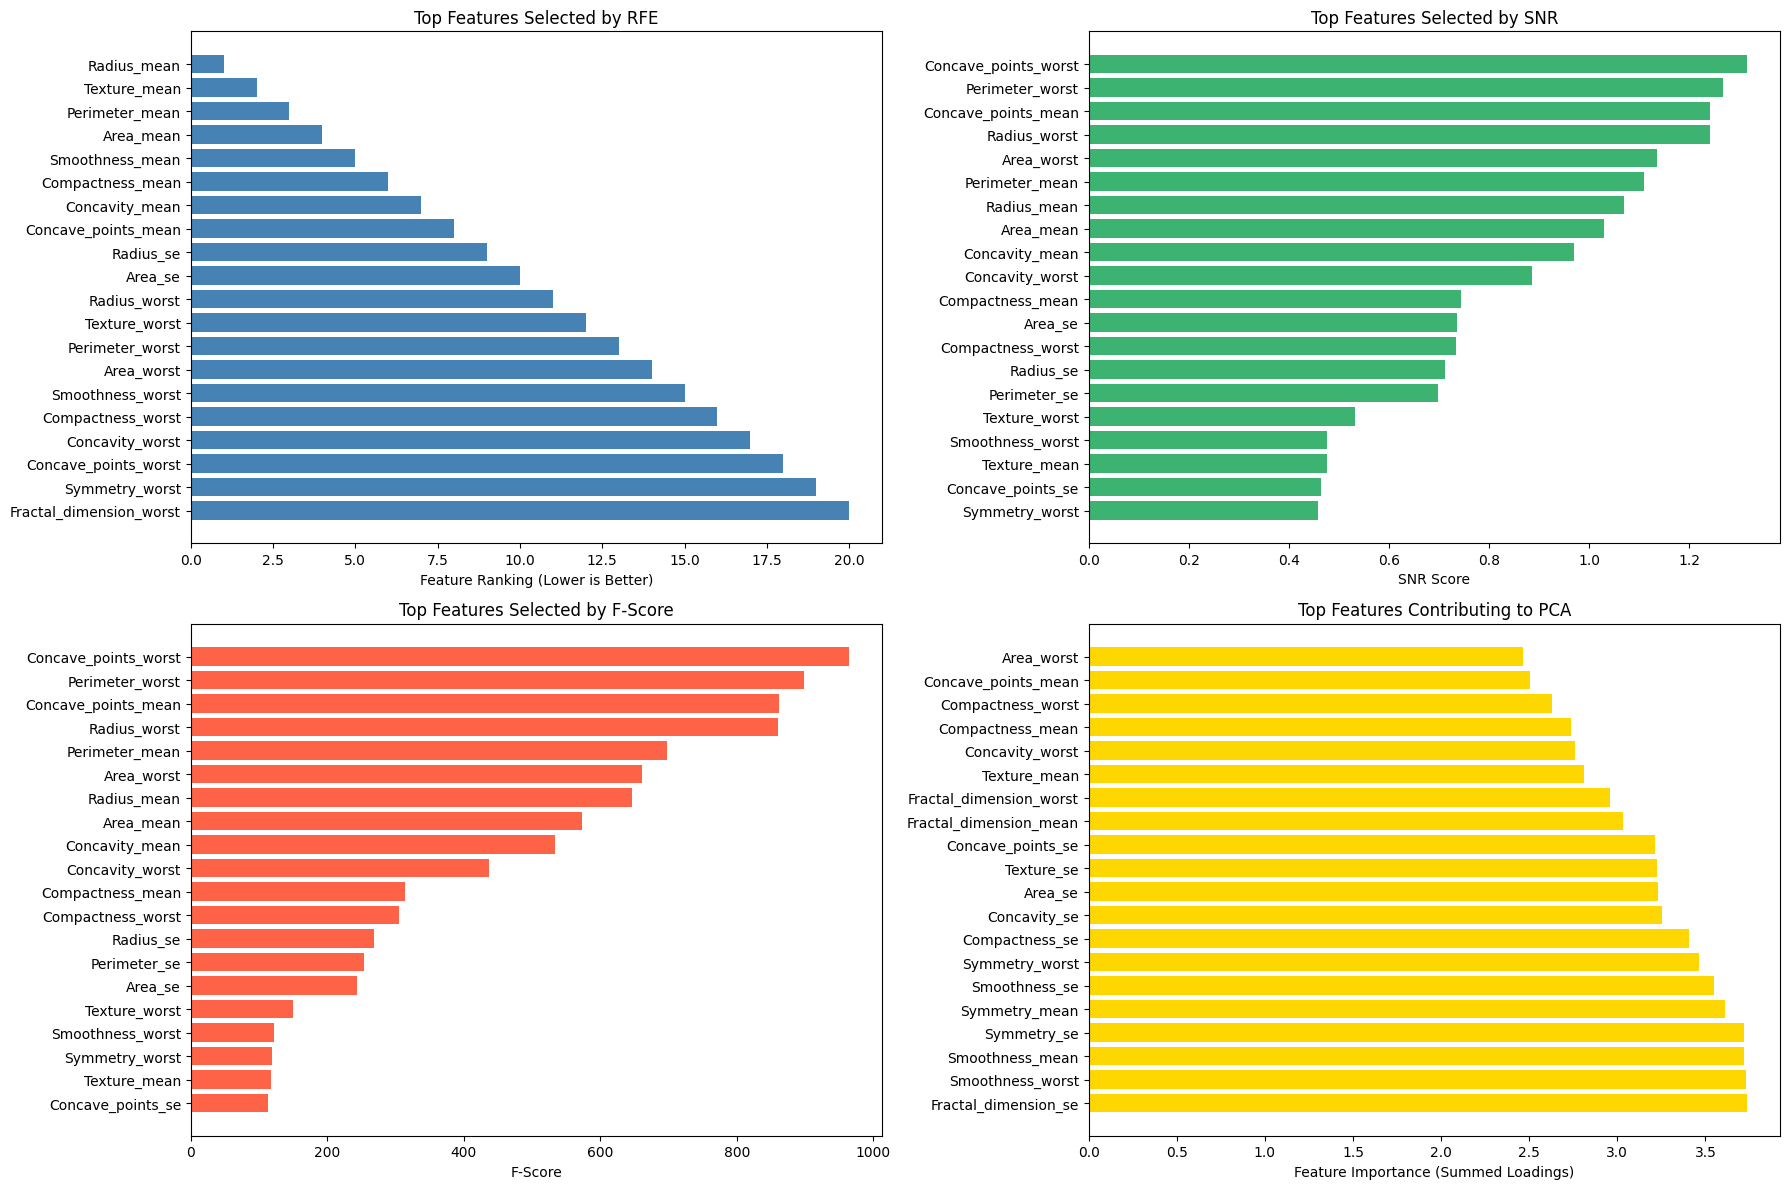

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for SNR
snr_scores = []
for i in range(X.shape[1]):
    mean_signal = np.mean(X[y == 1, i])  # Mean for 'M'
    mean_noise = np.mean(X[y == 0, i])   # Mean for 'B'
    std_signal = np.std(X[y == 1, i])
    std_noise = np.std(X[y == 0, i])
    snr = abs(mean_signal - mean_noise) / (std_signal + std_noise) if (std_signal + std_noise) != 0 else 0
    snr_scores.append((feature_names[i], snr))

snr_scores_sorted = sorted(snr_scores, key=lambda x: x[1], reverse=True)[:20]
snr_features, snr_values = zip(*snr_scores_sorted)

# Prepare data for F-Score
f_values, _ = f_classif(X, y)
f_scores = [(feature_names[i], f_values[i]) for i in range(len(feature_names))]
f_scores_sorted = sorted(f_scores, key=lambda x: x[1], reverse=True)[:20]
fscore_features, fscore_values = zip(*f_scores_sorted)

# Prepare data for PCA
explained_variance = pca_model.explained_variance_ratio_
components = [f"PC{i+1}" for i in range(len(explained_variance))]
feature_importance = np.abs(pca_model.components_).sum(axis=0)
top_feature_indices = np.argsort(feature_importance)[-20:]
top_feature_names = [feature_names[i] for i in top_feature_indices]
top_feature_scores = feature_importance[top_feature_indices]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# RFE
axes[0, 0].barh(rfe_selected_features, range(1, len(rfe_selected_features) + 1), color='steelblue')
axes[0, 0].set_title('Top Features Selected by RFE')
axes[0, 0].set_xlabel('Feature Ranking (Lower is Better)')
axes[0, 0].invert_yaxis()

# SNR
axes[0, 1].barh(snr_features, snr_values, color='mediumseagreen')
axes[0, 1].set_title('Top Features Selected by SNR')
axes[0, 1].set_xlabel('SNR Score')
axes[0, 1].invert_yaxis()

# F-Score
axes[1, 0].barh(fscore_features, fscore_values, color='tomato')
axes[1, 0].set_title('Top Features Selected by F-Score')
axes[1, 0].set_xlabel('F-Score')
axes[1, 0].invert_yaxis()

# PCA
axes[1, 1].barh(top_feature_names, top_feature_scores, color='gold')
axes[1, 1].set_title('Top Features Contributing to PCA')
axes[1, 1].set_xlabel('Feature Importance (Summed Loadings)')
axes[1, 1].invert_yaxis()

# Adjust layout
plt.tight_layout()
plt.show()


In [12]:
# Print RFE Selected Features
print("\nRFE Selected Features:")
for feature in rfe_selected_features:
    print(feature)

# Print SNR Selected Features
print("\nSNR Selected Features:")
for feature in snr_selected_features:
    print(feature)

# Print F-Score Selected Features
print("\nF-Score Selected Features:")
for feature in fscore_selected_features:
    print(feature)

# Print PCA Top Features
print("\nPCA Top Features:")
for feature in pca_top_features:
    print(feature)



RFE Selected Features:
Radius_mean
Texture_mean
Perimeter_mean
Area_mean
Smoothness_mean
Compactness_mean
Concavity_mean
Concave_points_mean
Radius_se
Area_se
Radius_worst
Texture_worst
Perimeter_worst
Area_worst
Smoothness_worst
Compactness_worst
Concavity_worst
Concave_points_worst
Symmetry_worst
Fractal_dimension_worst

SNR Selected Features:
Concave_points_worst
Perimeter_worst
Concave_points_mean
Radius_worst
Area_worst
Perimeter_mean
Radius_mean
Area_mean
Concavity_mean
Concavity_worst
Compactness_mean
Area_se
Compactness_worst
Radius_se
Perimeter_se
Texture_worst
Smoothness_worst
Texture_mean
Concave_points_se
Symmetry_worst

F-Score Selected Features:
Concave_points_worst
Perimeter_worst
Concave_points_mean
Radius_worst
Perimeter_mean
Area_worst
Radius_mean
Area_mean
Concavity_mean
Concavity_worst
Compactness_mean
Compactness_worst
Radius_se
Perimeter_se
Area_se
Texture_worst
Smoothness_worst
Symmetry_worst
Texture_mean
Concave_points_se

PCA Top Features:
Area_mean
Fractal_di

Model Training and Evaluation

In [13]:
# Function to build the deep learning model
def build_model(input_dim):
    model = Sequential([
        Dense(64, input_dim=input_dim, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    return model

# Function to perform k-Fold Cross-Validation and Train the Model
def train_evaluate_model(X, y, method_name, n_splits=5, epochs=50, batch_size=32):
    print(f"\n=== Training and Evaluating Model using {method_name} ===")
    
    # Train-test split (80/20)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Define k-fold cross-validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Store cross-validation results
    fold_accuracies = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        print(f"\n--- Fold {fold + 1} ---")
        
        # Split training and validation data for this fold
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
    
        # Define the model
        model = build_model(input_dim=X_train_fold.shape[1])
    
        # Compile the model
        learning_rate = 5e-5
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
        # Early stopping to prevent overfitting
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
        # Train the model
        history = model.fit(
            X_train_fold, y_train_fold,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val_fold, y_val_fold),
            callbacks=[early_stopping],
            verbose=0  # Set to 1 for detailed logs
        )
        print(f"Fold {fold + 1} Training Completed.")
    
        # Evaluate on the validation set
        val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
        fold_accuracies.append(val_accuracy)
        print(f"Fold {fold + 1} Validation Accuracy: {val_accuracy:.4f}")
    
    # Average cross-validation accuracy
    average_cv_accuracy = np.mean(fold_accuracies)
    print(f"\nAverage Cross-Validation Accuracy for {method_name}: {average_cv_accuracy:.4f}")
    
    # Retrain the model on the entire training set
    print(f"\n--- Retraining on Entire Training Set for {method_name} ---")
    model = build_model(input_dim=X_train.shape[1])
    model.compile(optimizer=Adam(learning_rate=5e-5), loss='binary_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping],
        verbose=0  # Set to 1 for detailed logs
    )
    
    # Evaluate on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Final Test Accuracy for {method_name}: {test_accuracy:.4f}")
    
    return {
        'method': method_name,
        'cv_accuracy': average_cv_accuracy,
        'test_accuracy': test_accuracy
    }
# List to store results
results = []

Evaluating Models for Each Feature Selection Method

In [14]:
# 1. RFE Selected Features
rfe_indices = [feature_names.index(feature) for feature in rfe_selected_features]
X_rfe = X[:, rfe_indices]
result_rfe = train_evaluate_model(X_rfe, y, method_name="RFE")
results.append(result_rfe)

# 2. SNR Selected Features
snr_indices = [feature_names.index(feature) for feature in snr_selected_features]
X_snr = X[:, snr_indices]
result_snr = train_evaluate_model(X_snr, y, method_name="SNR")
results.append(result_snr)

# 3. F-Score Selected Features
fscore_indices = [feature_names.index(feature) for feature in fscore_selected_features]
X_fscore = X[:, fscore_indices]
result_fscore = train_evaluate_model(X_fscore, y, method_name="F-Score")
results.append(result_fscore)

# 4. PCA Components
# Note: PCA has already transformed the data to components
result_pca = train_evaluate_model(X_pca_top, y, method_name="PCA")
results.append(result_pca)



=== Training and Evaluating Model using RFE ===

--- Fold 1 ---
Fold 1 Training Completed.
Fold 1 Validation Accuracy: 0.9560

--- Fold 2 ---
Fold 2 Training Completed.
Fold 2 Validation Accuracy: 0.9670

--- Fold 3 ---
Fold 3 Training Completed.
Fold 3 Validation Accuracy: 1.0000

--- Fold 4 ---
Fold 4 Training Completed.
Fold 4 Validation Accuracy: 0.9341

--- Fold 5 ---
Fold 5 Training Completed.
Fold 5 Validation Accuracy: 0.9341

Average Cross-Validation Accuracy for RFE: 0.9582

--- Retraining on Entire Training Set for RFE ---
Final Test Accuracy for RFE: 0.9649

=== Training and Evaluating Model using SNR ===

--- Fold 1 ---
Fold 1 Training Completed.
Fold 1 Validation Accuracy: 0.9341

--- Fold 2 ---
Fold 2 Training Completed.
Fold 2 Validation Accuracy: 0.9560

--- Fold 3 ---
Fold 3 Training Completed.
Fold 3 Validation Accuracy: 0.9560

--- Fold 4 ---
Fold 4 Training Completed.
Fold 4 Validation Accuracy: 0.9231

--- Fold 5 ---
Fold 5 Training Completed.
Fold 5 Validation A

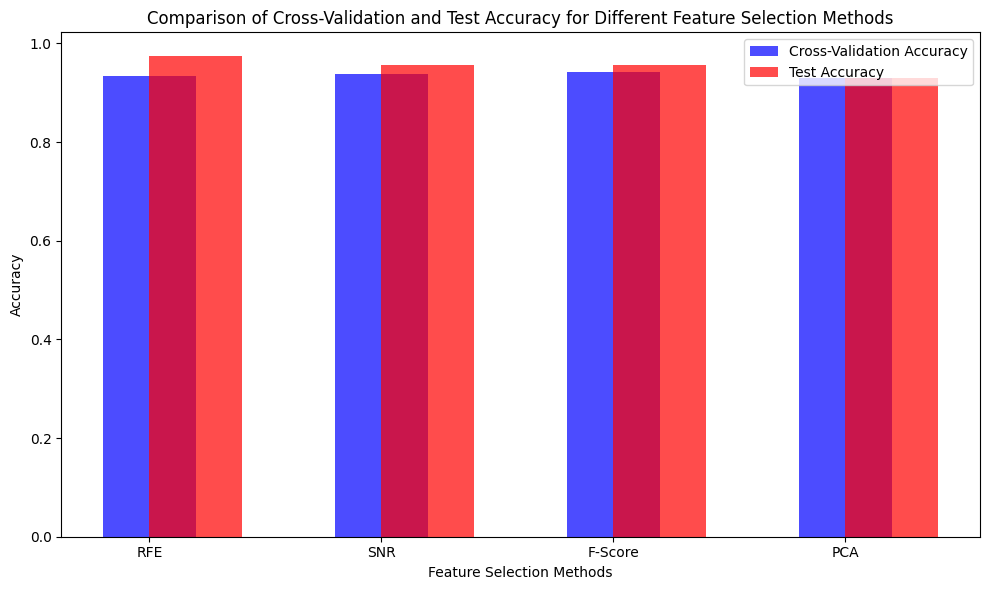

In [15]:
import matplotlib.pyplot as plt

# Method names
methods = ["RFE", "SNR", "F-Score", "PCA"]

# Cross-validation accuracies
cv_accuracies = [0.9341, 0.9385, 0.9429, 0.9297]

# Test accuracies
test_accuracies = [0.9737, 0.9561, 0.9561, 0.9298]

# Create subplots for comparison
fig, ax = plt.subplots(figsize=(10, 6))

# Plot cross-validation accuracies
ax.bar(methods, cv_accuracies, label='Cross-Validation Accuracy', alpha=0.7, color='b', width=0.4, align='center')

# Plot test accuracies
ax.bar(methods, test_accuracies, label='Test Accuracy', alpha=0.7, color='r', width=0.4, align='edge')

# Add labels and title
ax.set_xlabel('Feature Selection Methods')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Cross-Validation and Test Accuracy for Different Feature Selection Methods')

# Add legend
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()


RESULT SUMMARY

In [16]:

print("\n=== Summary of Model Performance ===")
summary_df = pd.DataFrame(results)
print(summary_df)

# Optionally, you can visualize the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
methods = summary_df['method']
cv_accuracies = summary_df['cv_accuracy']
test_accuracies = summary_df['test_accuracy']

x = np.arange(len(methods))
width = 0.35




=== Summary of Model Performance ===
    method  cv_accuracy  test_accuracy
0      RFE     0.958242       0.964912
1      SNR     0.942857       0.973684
2  F-Score     0.947253       0.973684
3      PCA     0.914286       0.964912


<Figure size 1000x600 with 0 Axes>

In [17]:
# Find common features among the methods and count them
def find_common_features_with_count(rfe_features, snr_features, fscore_features, pca_features):
    print("\nIdentifying Common Features")
    
    # Convert lists to sets
    rfe_set = set(rfe_features)
    snr_set = set(snr_features)
    fscore_set = set(fscore_features)
    pca_set = set(pca_features)
    
    # Find intersection of all sets
    common_features = list(rfe_set & snr_set & fscore_set & pca_set)
    total_common_features = len(common_features)
    
    # Print the common features vertically
    print(f"\nCommon Features Across All Methods ({total_common_features} features):")
    for feature in common_features:
        print(feature)

    # Return the common features and total count
    return common_features, total_common_features

# Call the function with selected features from each method
common_features, total_common_features = find_common_features_with_count(
    rfe_selected_features, 
    snr_selected_features, 
    fscore_selected_features, 
    pca_top_features
)



Identifying Common Features

Common Features Across All Methods (11 features):
Area_se
Smoothness_worst
Concave_points_worst
Compactness_worst
Symmetry_worst
Concavity_worst
Area_mean
Concave_points_mean
Area_worst
Radius_se
Compactness_mean


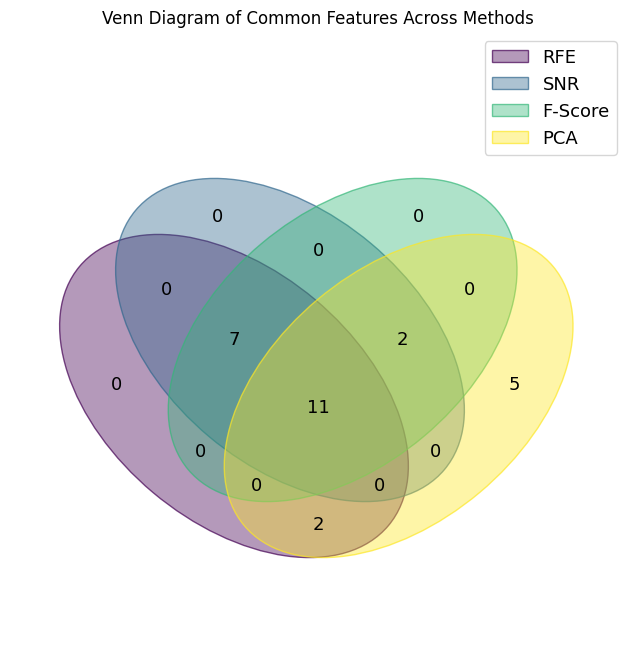

In [18]:
import matplotlib.pyplot as plt
from venn import venn # type: ignore

# Define the sets of features for each method
rfe_set = set(rfe_selected_features)
snr_set = set(snr_selected_features)
fscore_set = set(fscore_selected_features)
pca_set = set(pca_top_features)

# Prepare the data for the Venn diagram (4 sets)
venn_data = {
    'RFE': rfe_set,
    'SNR': snr_set,
    'F-Score': fscore_set,
    'PCA': pca_set
}

# Create the Venn diagram
venn(venn_data)

# Add a title to the diagram
plt.title("Venn Diagram of Common Features Across Methods")
plt.show()


dataset prep

In [19]:
# Prepare dataset for common features
if total_common_features > 0:
    common_feature_indices = [feature_names.index(feature) for feature in common_features]
    X_common = X[:, common_feature_indices]
    print(f"\nDataset prepared using {total_common_features} common features.")
else:
    raise ValueError("No common features found. Cannot proceed with classification.")



Dataset prepared using 11 common features.


knn


In [20]:
# KNN Classification
def knn_classifier(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    knn = KNeighborsClassifier(n_neighbors=5)  
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"KNN Accuracy: {accuracy:.4f}")
    return accuracy
knn_accuracy = knn_classifier(X_common, y)

KNN Accuracy: 0.9298


svm


In [21]:
# SVM Classification
def svm_classifier(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    svm = SVC(kernel='rbf', random_state=42)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"SVM Accuracy: {accuracy:.4f}")
    return accuracy
svm_accuracy = svm_classifier(X_common, y)

SVM Accuracy: 0.9474


Logistic Regression Classification

In [22]:

# Logistic Regression Classification
def logistic_regression_classifier(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    lr = LogisticRegression(random_state=42)  # You can tune `solver` and `C`
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Logistic Regression Accuracy: {accuracy:.4f}")
    return accuracy

lr_accuracy = logistic_regression_classifier(X_common, y)


Logistic Regression Accuracy: 0.9825


Random Forest Classification

In [23]:

# Random Forest Classification
def random_forest_classifier(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    rf = RandomForestClassifier(n_estimators=100, random_state=42)  # You can tune `n_estimators`
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Random Forest Accuracy: {accuracy:.4f}")
    return accuracy

rf_accuracy = random_forest_classifier(X_common, y)


Random Forest Accuracy: 0.9561


summary of classification

In [24]:
# Summarize results
results = {
    "KNN Accuracy": knn_accuracy,
    "SVM Accuracy": svm_accuracy,
    "Random Forest Accuracy": rf_accuracy,
    "Logistic Regression Accuracy": lr_accuracy
}

print("\n=== Summary of Classifier Accuracies ===")
for classifier, accuracy in results.items():
    print(f"{classifier}: {accuracy:.4f}")



=== Summary of Classifier Accuracies ===
KNN Accuracy: 0.9298
SVM Accuracy: 0.9474
Random Forest Accuracy: 0.9561
Logistic Regression Accuracy: 0.9825


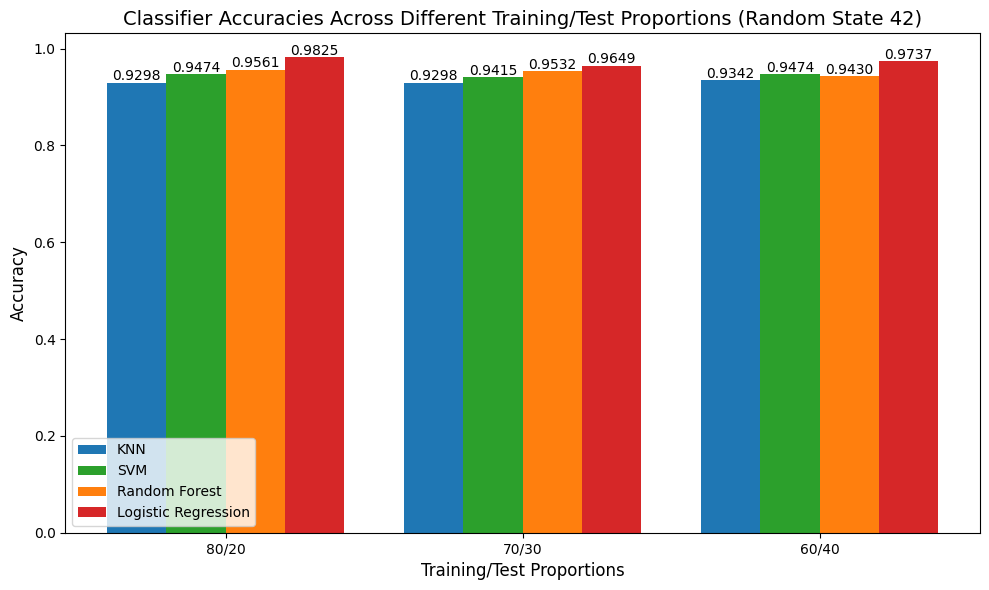

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Data for each classifier and training/testing proportions
proportions = ['80/20', '70/30', '60/40']
knn_accuracies = [0.9298, 0.9298, 0.9342]
svm_accuracies = [0.9474, 0.9415, 0.9474]
rf_accuracies = [0.9561, 0.9532, 0.9430]
lr_accuracies = [0.9825, 0.9649, 0.9737]

# Set width of bars
bar_width = 0.2

# Set positions of the bars on the x-axis
index = np.arange(len(proportions))

# Create a figure and axes
plt.figure(figsize=(10, 6))

# Plot bars for each classifier using standard colors
plt.bar(index, knn_accuracies, bar_width, label='KNN', color='tab:blue')
plt.bar(index + bar_width, svm_accuracies, bar_width, label='SVM', color='tab:green')
plt.bar(index + 2*bar_width, rf_accuracies, bar_width, label='Random Forest', color='tab:orange')
plt.bar(index + 3*bar_width, lr_accuracies, bar_width, label='Logistic Regression', color='tab:red')

# Add title and labels
plt.title('Classifier Accuracies Across Different Training/Test Proportions (Random State 42)', fontsize=14)
plt.xlabel('Training/Test Proportions', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(index + 1.5 * bar_width, proportions)  # Adjust x-ticks to center under grouped bars

# Display accuracy values on top of each bar
for i in range(len(proportions)):
    plt.text(i, knn_accuracies[i] + 0.005, f'{knn_accuracies[i]:.4f}', ha='center', fontsize=10)
    plt.text(i + bar_width, svm_accuracies[i] + 0.005, f'{svm_accuracies[i]:.4f}', ha='center', fontsize=10)
    plt.text(i + 2*bar_width, rf_accuracies[i] + 0.005, f'{rf_accuracies[i]:.4f}', ha='center', fontsize=10)
    plt.text(i + 3*bar_width, lr_accuracies[i] + 0.005, f'{lr_accuracies[i]:.4f}', ha='center', fontsize=10)

# Add legend
plt.legend()

# Layout adjustments
plt.tight_layout()

# Show the plot
plt.show()


80/20
=== Summary of Classifier Accuracies ===
KNN Accuracy: 0.9298
SVM Accuracy: 0.9474
Random Forest Accuracy: 0.9561
Logistic Regression Accuracy: 0.9825



70/30
=== Summary of Classifier Accuracies ===
KNN Accuracy: 0.9298
SVM Accuracy: 0.9415
Random Forest Accuracy: 0.9532
Logistic Regression Accuracy: 0.9649



60/40
=== Summary of Classifier Accuracies ===
KNN Accuracy: 0.9342
SVM Accuracy: 0.9474
Random Forest Accuracy: 0.9430
Logistic Regression Accuracy: 0.9737




In [26]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score

def calculate_metrics(y_true, y_pred, y_proba=None):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Sensitivity (Recall for positive class)
    sensitivity = tp / (tp + fn)
    
    # Specificity
    specificity = tn / (tn + fp)
    
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    # F1 Score
    f_score = f1_score(y_true, y_pred)
    
    # AUC-ROC
    auc_roc = roc_auc_score(y_true, y_proba) if y_proba is not None else None
    
    return {
        "Accuracy": accuracy,
        "F-Score": f_score,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "AUC-ROC": auc_roc
    }


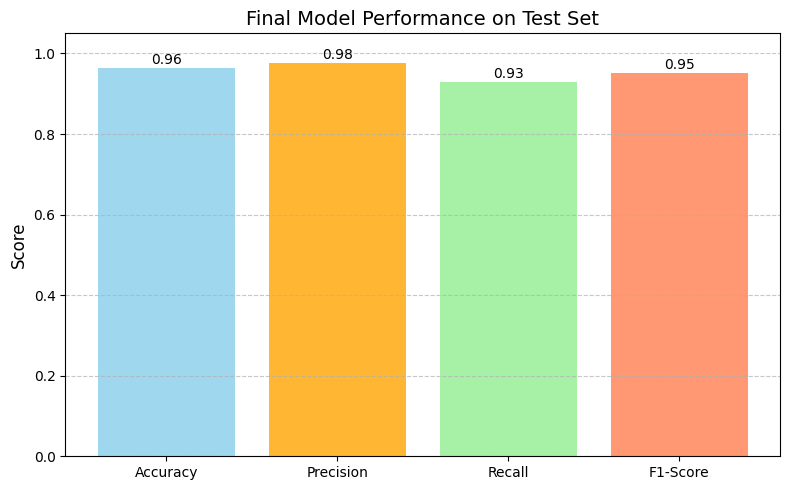

In [27]:
import matplotlib.pyplot as plt

# Example performance metrics (replace with actual values)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
scores = [0.9649, 0.9756, 0.9302, 0.9524]  # Replace these with your model's scores

# Create a bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, scores, color=['skyblue', 'orange', 'lightgreen', 'coral'], alpha=0.8)

# Add value annotations on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.2f}', ha='center', fontsize=10)

# Customize the plot
plt.title('Final Model Performance on Test Set', fontsize=14)
plt.ylabel('Score', fontsize=12)
plt.ylim(0, 1.05)  # Scores range from 0 to 1
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


Training fold 1/5
Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7657 - loss: 0.5707 - val_accuracy: 0.9298 - val_loss: 0.5549
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7800 - loss: 0.5541 - val_accuracy: 0.9386 - val_loss: 0.5428
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7970 - loss: 0.5324 - val_accuracy: 0.9474 - val_loss: 0.5308
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8282 - loss: 0.5344 - val_accuracy: 0.9474 - val_loss: 0.5189
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7785 - loss: 0.5414 - val_accuracy: 0.9474 - val_loss: 0.5076
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8059 - loss: 0.5276 - val_accuracy: 0.9474 - val_loss: 0.4967
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8107 - loss: 0.5302 - val_accuracy: 0.9474 - val_loss: 0.4860
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8330 - loss: 0.4991 - val_accuracy: 

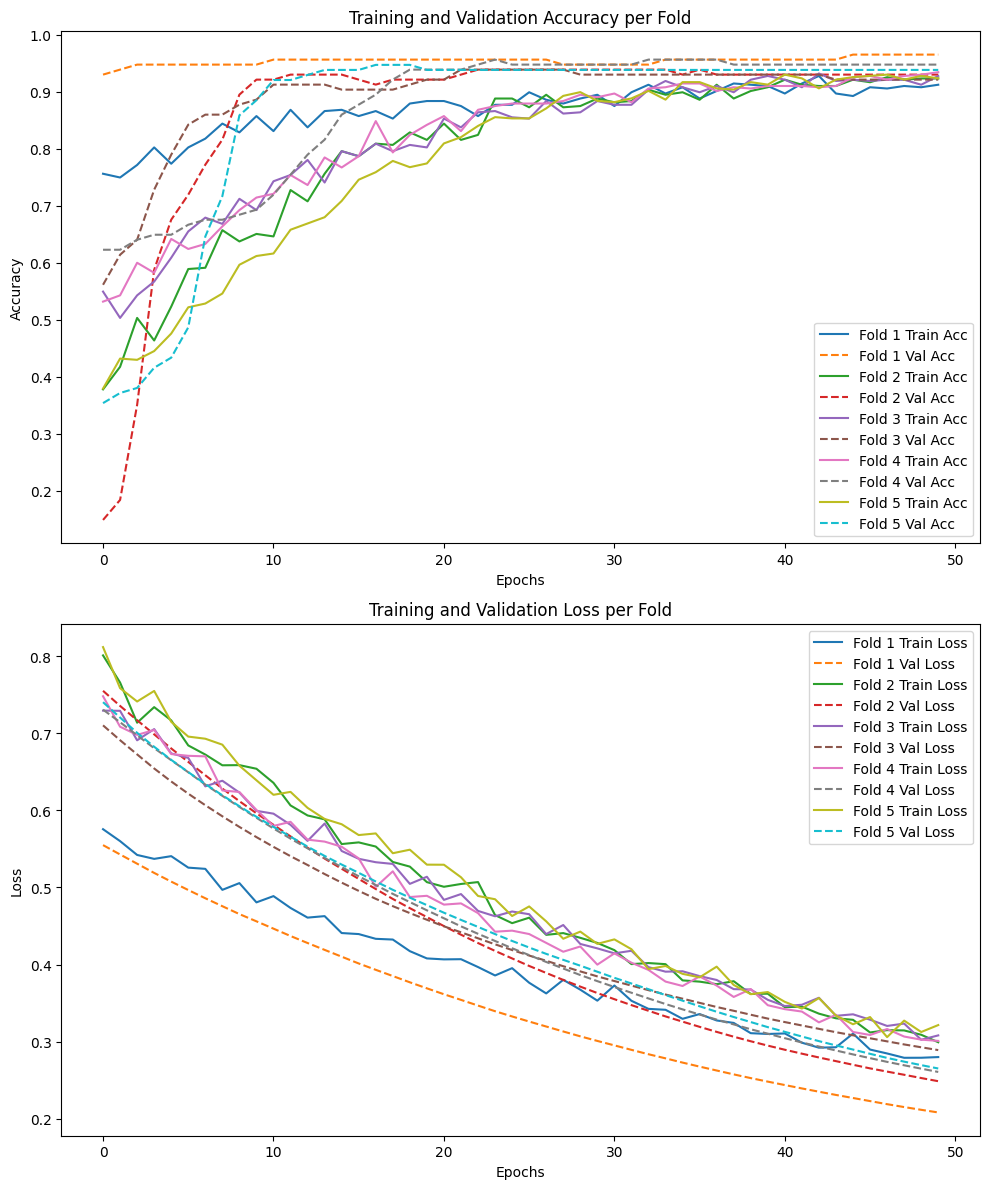

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Example Dataset Setup (Ensure you load your actual dataset here)
data = pd.read_csv('wdbc.csv')

# Preprocessing: Encode the target and prepare features/target
label_encoder = LabelEncoder()
data['diagnosis'] = label_encoder.fit_transform(data['diagnosis'])  # M -> 1, B -> 0
X = data.drop(columns=['diagnosis'])
y = data['diagnosis']

# Feature selection
k = 10
selector = SelectKBest(score_func=f_classif, k=k)
X_selected = selector.fit_transform(X, y)
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameters
epochs = 50
batch_size = 32
learning_rate = 5e-5

# K-Fold Cross-Validation Loop with Graph Data Collection
fold_accuracies = []
fold_histories = []  # To store history for each fold

for fold, (train_index, val_index) in enumerate(kf.split(X_selected)):
    print(f"Training fold {fold + 1}/{kf.get_n_splits()}")
    
    # Split data into training and validation sets for each fold
    X_train, X_val = X_selected[train_index], X_selected[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Define the model
    model = Sequential([
        Dense(64, input_dim=X_train.shape[1], activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    
    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the model and store history
    history = model.fit(
        X_train, y_train, 
        epochs=epochs, 
        batch_size=batch_size, 
        validation_data=(X_val, y_val), 
        verbose=1
    )
    fold_histories.append(history)  # Save fold history
    
    # Evaluate the model
    _, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    fold_accuracies.append(val_accuracy)
    print(f"Validation Accuracy for fold {fold + 1}: {val_accuracy:.4f}")

# Plot Accuracy and Loss for Each Fold
fig, axes = plt.subplots(2, 1, figsize=(10, 12))
for fold, history in enumerate(fold_histories):
    # Plot training and validation accuracy
    axes[0].plot(history.history['accuracy'], label=f'Fold {fold + 1} Train Acc')
    axes[0].plot(history.history['val_accuracy'], linestyle='--', label=f'Fold {fold + 1} Val Acc')
    
    # Plot training and validation loss
    axes[1].plot(history.history['loss'], label=f'Fold {fold + 1} Train Loss')
    axes[1].plot(history.history['val_loss'], linestyle='--', label=f'Fold {fold + 1} Val Loss')

# Configure Accuracy Plot
axes[0].set_title('Training and Validation Accuracy per Fold')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Configure Loss Plot
axes[1].set_title('Training and Validation Loss per Fold')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Show the plots
plt.tight_layout()
plt.show()